In [ ]:
#install and load relevant libraries

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_parquet('/content/drive/MyDrive/FEMA Flood Claim/FimaNfipClaims.parquet')

In [ ]:
# prompt: get structure of df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712269 entries, 0 to 2712268
Data columns (total 73 columns):
 #   Column                                      Dtype              
---  ------                                      -----              
 0   agricultureStructureIndicator               bool               
 1   asOfDate                                    datetime64[us, UTC]
 2   basementEnclosureCrawlspaceType             float64            
 3   policyCount                                 int16              
 4   crsClassificationCode                       float64            
 5   dateOfLoss                                  object             
 6   elevatedBuildingIndicator                   bool               
 7   elevationCertificateIndicator               object             
 8   elevationDifference                         object             
 9   baseFloodElevation                          object             
 10  ratedFloodZone                              object    


Water depth statistics after cleaning:
count    1.850889e+06
mean     5.708270e+00
std      1.797806e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      9.990000e+02
Name: waterDepth, dtype: float64


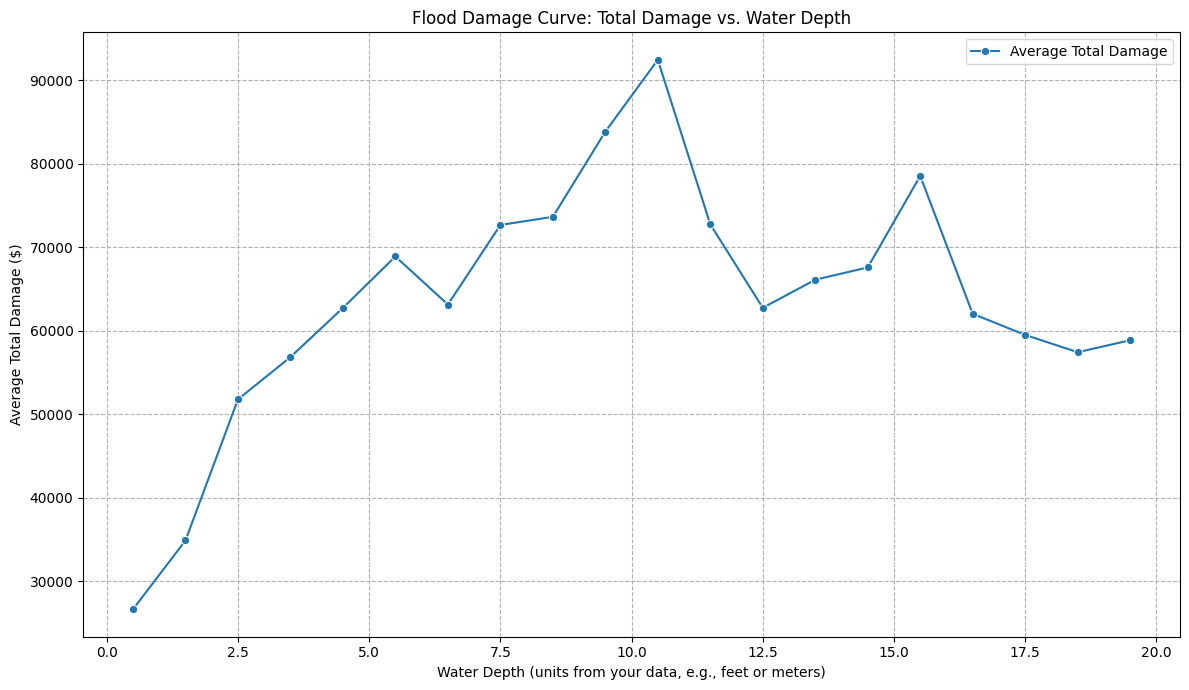


Damage Curve Data (Average Damage per Depth Bin):
   depth_midpoint          mean   count
0             0.5  26644.389829  557098
1             1.5  34880.563219  523667
2             2.5  51787.217931  204836
3             3.5  56854.270955  116171
4             4.5  62743.266208   79539
5             5.5  68904.185273   48589
6             6.5  63142.535644   41519
7             7.5  72675.522680   24719
8             8.5  73651.089310   28358
9             9.5  83855.042878   13382
10           10.5  92462.623525   22808
11           11.5  72754.045467    6080
12           12.5  62754.379235   24991
13           13.5  66117.382880    4812
14           14.5  67590.632095    7459
15           15.5  78555.238040    6173
16           16.5  62036.484487    5690
17           17.5  59506.550726    3514
18           18.5  57434.494637    7058
19           19.5  58866.721926    2829


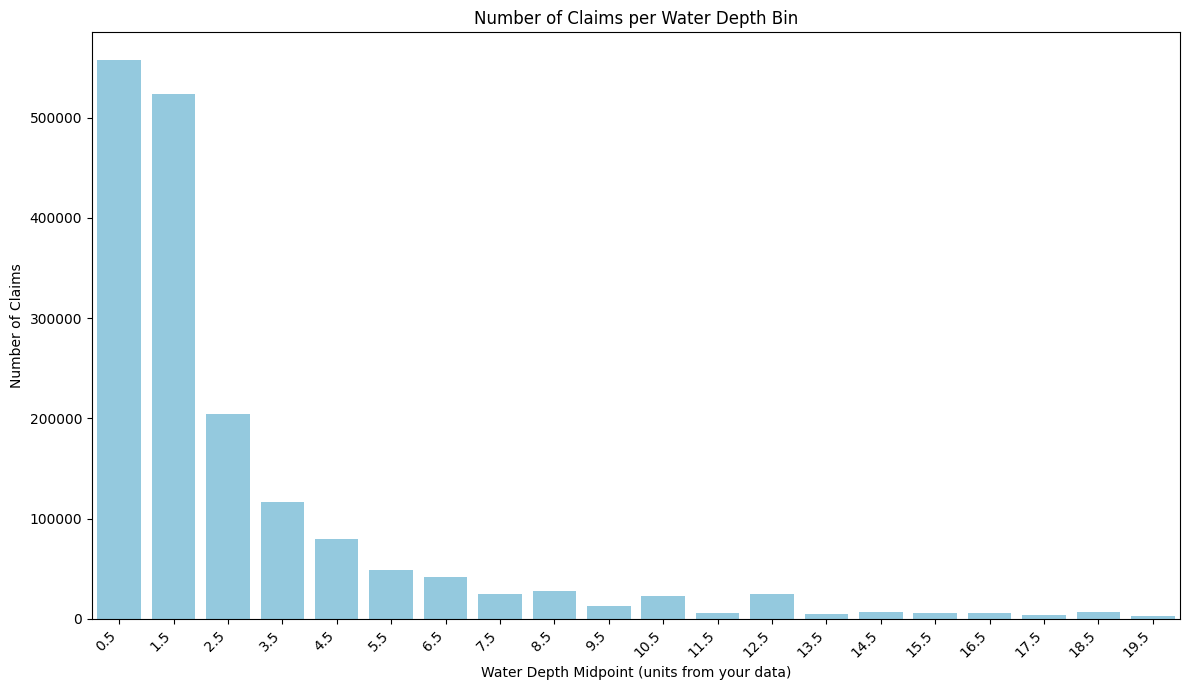

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive # No need to import drive again

# --- 0. Mount Google Drive ---
# This will prompt you for authorization.
# drive.mount('/content/drive') # Already mounted in a previous cell

# --- 1. Load Your Data ---
# Data is already loaded into df in a previous cell.
# The following code assumes 'df' DataFrame already exists in the environment.

# file_path_in_drive = '/content/drive/My Drive/REPLACE_WITH_YOUR_FILE_PATH.csv' # <--- CHANGE THIS

# try:
#     df = pd.read_csv(file_path_in_drive)
#     print("File loaded successfully!")
#     print("DataFrame head:")
#     print(df.head())
#     print("\nDataFrame info:")
#     df.info()
# except FileNotFoundError:
#     print(f"ERROR: File not found at {file_path_in_drive}")
#     print("Please ensure the path is correct and the file exists in your Google Drive.")
#     # Exit or raise error if file not found, as rest of script depends on df
#     raise
# except Exception as e:
#     print(f"An error occurred while loading the file: {e}")
#     raise

# --- 2. Data Preparation ---
# Ensure the relevant columns are numeric.
# If 'buildingDamageAmount', 'contentsDamageAmount', or 'waterDepth' are not already numeric,
# you would convert them like this (errors='coerce' will turn non-numeric values into NaN):
df['buildingDamageAmount'] = pd.to_numeric(df['amountPaidOnBuildingClaim'], errors='coerce') # Use 'amountPaidOnBuildingClaim' based on info()
df['contentsDamageAmount'] = pd.to_numeric(df['amountPaidOnContentsClaim'], errors='coerce') # Use 'amountPaidOnContentsClaim' based on info()
df['waterDepth'] = pd.to_numeric(df['waterDepth'], errors='coerce')

# Create total damage column
# Fill NaNs with 0 for damage amounts if missing means zero damage for that component.
df['totalDamage'] = df['buildingDamageAmount'].fillna(0) + df['contentsDamageAmount'].fillna(0)

# Select and clean necessary columns
# Drop rows where waterDepth is NaN or where totalDamage calculation resulted in issues
# (e.g., if original damage components were NaN and not filled, or if waterDepth is essential)
df_cleaned = df[['waterDepth', 'totalDamage']].copy() # Use .copy() to avoid SettingWithCopyWarning
df_cleaned.dropna(subset=['waterDepth', 'totalDamage'], inplace=True)


# Filter out non-positive water depths if they don't make sense for your analysis
df_cleaned = df_cleaned[df_cleaned['waterDepth'] >= 0]
# Filter out non-positive total damage if it doesn't make sense for a damage curve
# (often, damage curves focus on instances where actual damage occurred)
df_cleaned = df_cleaned[df_cleaned['totalDamage'] > 0]

if df_cleaned.empty:
    print("DataFrame is empty after cleaning and filtering. Cannot proceed with plotting.")
    # Exit or handle this case appropriately
else:
    # --- 3. Binning Water Depth ---
    print("\nWater depth statistics after cleaning:")
    print(df_cleaned['waterDepth'].describe())

    max_depth = df_cleaned['waterDepth'].max()
    if pd.isna(max_depth) or max_depth == 0:
        print("Max water depth is 0 or NaN after cleaning. Cannot create meaningful bins.")
    else:
        # Define bins for water depth. Adjust based on your data's distribution.
        # Example: Bins of 1 unit (e.g., foot or meter) up to a sensible maximum like 20, or rounded max_depth.
        step = 1.0 # Adjust step size as needed (e.g., 0.5 for half-unit increments)
        upper_bin_limit = min(np.ceil(max_depth / step) * step + step, 20 + step) # Cap at 20 or rounded max
        bins = np.arange(0, upper_bin_limit, step)

        if len(bins) < 2: # Ensure at least one interval
            bins = [0, max_depth if max_depth > 0 else step] # Fallback for very small range

        df_cleaned.loc[:, 'depth_bin'] = pd.cut(df_cleaned['waterDepth'], bins=bins, include_lowest=True, right=False) # Using right=False for [start, end) intervals

        # --- 4. Calculate Average Damage per Bin ---
        damage_curve_data = df_cleaned.groupby('depth_bin')['totalDamage'].agg(['mean', 'count']).reset_index()

        # Use the midpoint of the bins for plotting
        damage_curve_data['depth_midpoint'] = damage_curve_data['depth_bin'].apply(lambda x: x.mid if pd.notna(x) else np.nan)
        damage_curve_data.dropna(subset=['depth_midpoint'], inplace=True) # Remove rows if bin was problematic

        if not damage_curve_data.empty:
            # --- 5. Plotting the Damage Curve ---
            plt.figure(figsize=(12, 7))
            sns.lineplot(x='depth_midpoint', y='mean', data=damage_curve_data, marker='o', label='Average Total Damage')

            plt.xlabel("Water Depth (units from your data, e.g., feet or meters)")
            plt.ylabel("Average Total Damage ($)")
            plt.title("Flood Damage Curve: Total Damage vs. Water Depth")
            plt.legend()
            plt.grid(True, which="both", ls="--")
            plt.tight_layout()
            plt.show()

            print("\nDamage Curve Data (Average Damage per Depth Bin):")
            print(damage_curve_data[['depth_midpoint', 'mean', 'count']])

            # --- Optional: Plot number of claims per bin ---
            plt.figure(figsize=(12, 7))
            # Ensure depth_midpoint is treated as categorical for bar plot or sort it if numerical
            damage_curve_data_sorted = damage_curve_data.sort_values('depth_midpoint')
            sns.barplot(x='depth_midpoint', y='count', data=damage_curve_data_sorted, color='skyblue', order=damage_curve_data_sorted['depth_midpoint'])
            plt.xlabel("Water Depth Midpoint (units from your data)")
            plt.ylabel("Number of Claims")
            plt.title("Number of Claims per Water Depth Bin")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("No data available for plotting after binning. This might happen if bins don't align with data or all data was filtered out.")


Water depth statistics after cleaning:
count    1.850889e+06
mean     5.708270e+00
std      1.797806e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      9.990000e+02
Name: waterDepth, dtype: float64


<ipython-input-13-8fc5ad42e867>:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  damage_curve_data = df_cleaned.groupby('depth_bin')['totalDamage'].agg(['mean', 'count']).reset_index()


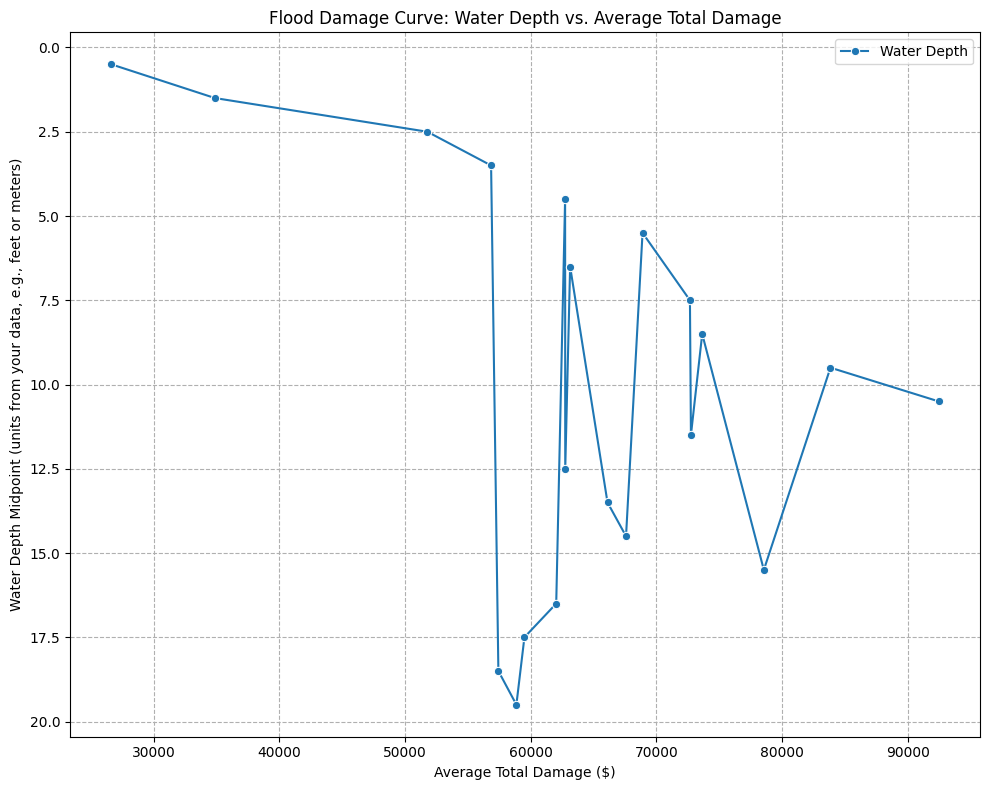


Damage Curve Data (Average Damage per Original Depth Bin):
   depth_midpoint          mean   count
0             0.5  26644.389829  557098
1             1.5  34880.563219  523667
2             2.5  51787.217931  204836
3             3.5  56854.270955  116171
18           18.5  57434.494637    7058
19           19.5  58866.721926    2829
17           17.5  59506.550726    3514
16           16.5  62036.484487    5690
4             4.5  62743.266208   79539
12           12.5  62754.379235   24991
6             6.5  63142.535644   41519
13           13.5  66117.382880    4812
14           14.5  67590.632095    7459
5             5.5  68904.185273   48589
7             7.5  72675.522680   24719
11           11.5  72754.045467    6080
8             8.5  73651.089310   28358
15           15.5  78555.238040    6173
9             9.5  83855.042878   13382
10           10.5  92462.623525   22808


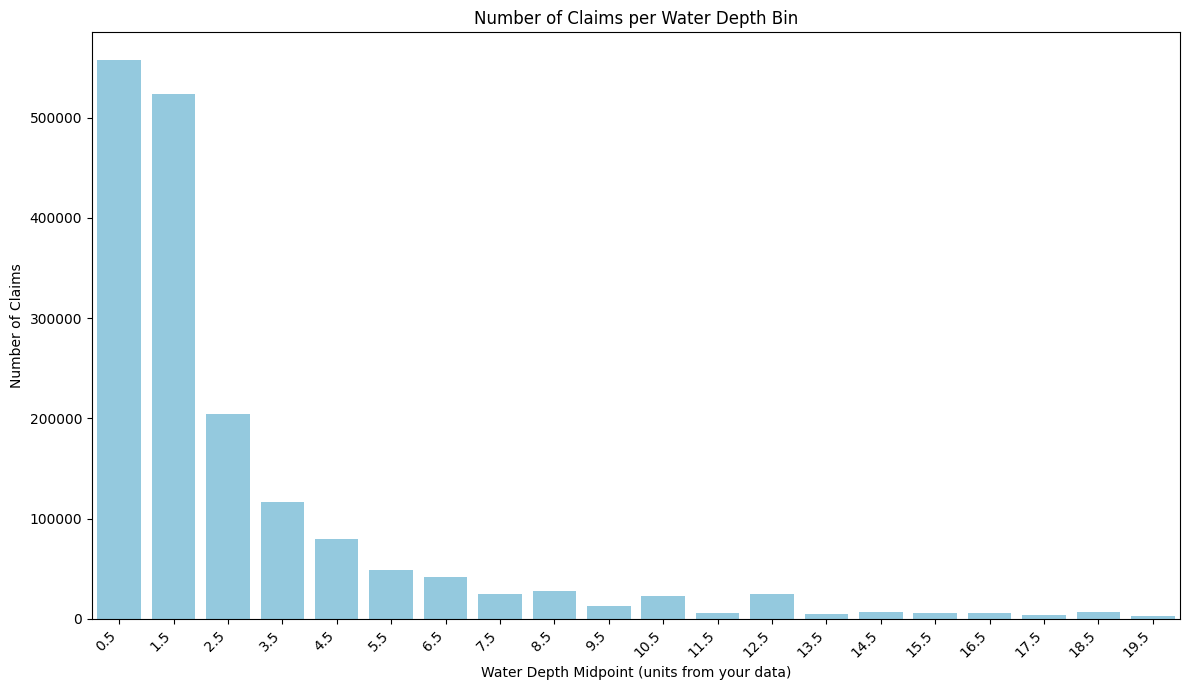

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive # No need to import drive again

# --- 0. Mount Google Drive ---
# This will prompt you for authorization.
# drive.mount('/content/drive') # Already mounted in a previous cell

# --- 1. Load Your Data ---
# Data is already loaded into df in a previous cell.
# The following code assumes 'df' DataFrame already exists in the environment.

# --- 2. Data Preparation ---
# Ensure the relevant columns are numeric.
# User updated to use 'amountPaidOnBuildingClaim' and 'amountPaidOnContentsClaim'
df['buildingDamageAmount'] = pd.to_numeric(df['amountPaidOnBuildingClaim'], errors='coerce')
df['contentsDamageAmount'] = pd.to_numeric(df['amountPaidOnContentsClaim'], errors='coerce')
df['waterDepth'] = pd.to_numeric(df['waterDepth'], errors='coerce')

# Create total damage column
# Fill NaNs with 0 for damage amounts if missing means zero damage for that component.
df['totalDamage'] = df['buildingDamageAmount'].fillna(0) + df['contentsDamageAmount'].fillna(0)

# Select and clean necessary columns
df_cleaned = df[['waterDepth', 'totalDamage']].copy()
df_cleaned.dropna(subset=['waterDepth', 'totalDamage'], inplace=True)

# Filter out non-positive water depths if they don't make sense for your analysis
df_cleaned = df_cleaned[df_cleaned['waterDepth'] >= 0]
# Filter out non-positive total damage if it doesn't make sense for a damage curve
df_cleaned = df_cleaned[df_cleaned['totalDamage'] > 0]

if df_cleaned.empty:
    print("DataFrame is empty after cleaning and filtering. Cannot proceed with plotting.")
else:
    # --- 3. Binning Water Depth ---
    print("\nWater depth statistics after cleaning:")
    print(df_cleaned['waterDepth'].describe())

    max_depth = df_cleaned['waterDepth'].max()
    if pd.isna(max_depth) or max_depth == 0:
        print("Max water depth is 0 or NaN after cleaning. Cannot create meaningful bins for water depth.")
    else:
        # Define bins for water depth. Adjust based on your data's distribution.
        step = 1.0
        upper_bin_limit = min(np.ceil(max_depth / step) * step + step, 20 + step)
        bins = np.arange(0, upper_bin_limit, step)

        if len(bins) < 2:
            bins = [0, max_depth if max_depth > 0 else step]

        df_cleaned.loc[:, 'depth_bin'] = pd.cut(df_cleaned['waterDepth'], bins=bins, include_lowest=True, right=False)

        # --- 4. Calculate Average Damage per Water Depth Bin ---
        # This part remains the same: we are still calculating average damage for each water depth bin.
        # The 'mean' column here refers to the mean of 'totalDamage'.
        damage_curve_data = df_cleaned.groupby('depth_bin')['totalDamage'].agg(['mean', 'count']).reset_index()
        damage_curve_data['depth_midpoint'] = damage_curve_data['depth_bin'].apply(lambda x: x.mid if pd.notna(x) else np.nan)
        damage_curve_data.dropna(subset=['depth_midpoint', 'mean'], inplace=True) # Ensure 'mean' is also not NaN

        if not damage_curve_data.empty:
            # --- 5. Plotting the Damage Curve (Axes Flipped) ---
            plt.figure(figsize=(10, 8)) # Adjusted figure size for potentially vertical orientation

            # Sort data by the new x-axis ('mean' of totalDamage) for a coherent line plot
            damage_curve_data_sorted_for_plot = damage_curve_data.sort_values('mean')

            # MODIFIED: Swap x and y axes in the lineplot call
            sns.lineplot(x='mean', y='depth_midpoint', data=damage_curve_data_sorted_for_plot, marker='o', label='Water Depth')

            # MODIFIED: Update labels and title
            plt.xlabel("Average Total Damage ($)")
            plt.ylabel("Water Depth Midpoint (units from your data, e.g., feet or meters)")
            plt.title("Flood Damage Curve: Water Depth vs. Average Total Damage")
            plt.legend()
            plt.grid(True, which="both", ls="--")
            plt.tight_layout()
            plt.show()

            print("\nDamage Curve Data (Average Damage per Original Depth Bin):")
            # Displaying the data used for the plot (note 'mean' is avg damage, 'depth_midpoint' is from depth bins)
            print(damage_curve_data[['depth_midpoint', 'mean', 'count']].sort_values('mean'))

            # --- Optional: Plot number of claims per original water depth bin ---
            # This plot still shows counts based on the original water depth binning, which can be useful context.
            plt.figure(figsize=(12, 7))
            damage_curve_data_sorted_by_depth = damage_curve_data.sort_values('depth_midpoint')
            sns.barplot(x='depth_midpoint', y='count', data=damage_curve_data_sorted_by_depth, color='skyblue', order=damage_curve_data_sorted_by_depth['depth_midpoint'].astype(str)) # astype(str) if midpoints are not unique for barplot ordering
            plt.xlabel("Water Depth Midpoint (units from your data)")
            plt.ylabel("Number of Claims")
            plt.title("Number of Claims per Water Depth Bin")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("No data available for plotting after binning. This might happen if bins don't align with data or all data was filtered out.")

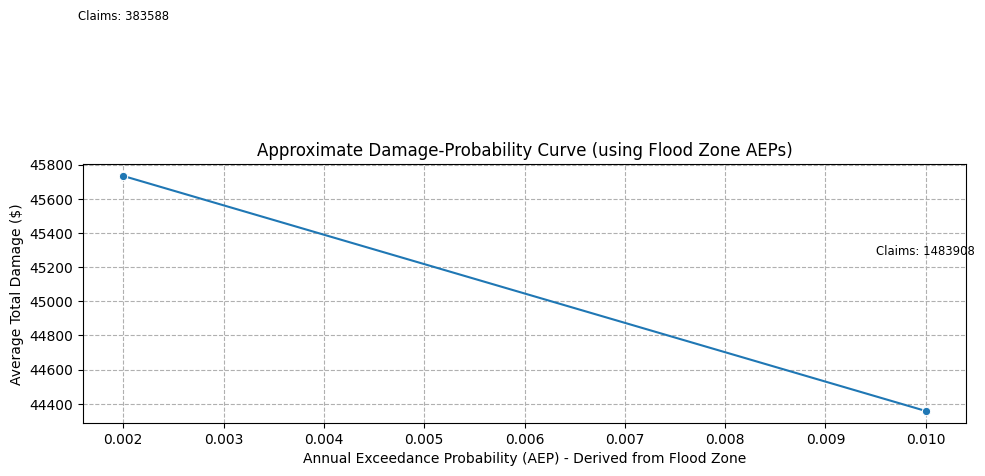


Data used for the plot:
     AEP  averageTotalDamage  numberOfClaims
0  0.002        45733.881809          383588
1  0.010        44357.951569         1483908

--- Important Notes on Interpretation ---
1. This plot is an approximation using flood zones as proxies for event probabilities.
2. The 'AEP' values are based on generalized mappings (e.g., AE=0.01, X/B=0.002).
   Verify these mappings against FEMA definitions and the specifics of your 'ratedFloodZone' data.
3. The y-axis shows the AVERAGE damage for claims within each AEP-zone category.
4. A true damage-probability curve often requires more detailed hydrological modeling to link specific damage levels to their annual probabilities.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' DataFrame is already loaded and 'totalDamage' is calculated.
# If not, you'd have:
# df['buildingDamageAmount'] = pd.to_numeric(df['amountPaidOnBuildingClaim'], errors='coerce')
# df['contentsDamageAmount'] = pd.to_numeric(df['amountPaidOnContentsClaim'], errors='coerce')
# df['totalDamage'] = df['buildingDamageAmount'].fillna(0) + df['contentsDamageAmount'].fillna(0)

# --- 1. Data Preparation for this specific plot ---
# Select relevant columns and drop rows with missing critical data
plot_df = df[['ratedFloodZone', 'totalDamage']].copy()
plot_df.dropna(subset=['ratedFloodZone', 'totalDamage'], inplace=True)
plot_df = plot_df[plot_df['totalDamage'] > 0] # Focus on actual damages

# --- 2. Define Flood Zone to AEP Mapping Function ---
# This mapping is a critical assumption and may need adjustment based on your specific
# understanding of the flood zones in your data and FEMA definitions.
def map_flood_zone_to_aep(zone_str):
    if pd.isna(zone_str):
        return None
    zone_str = str(zone_str).strip().upper()

    # 1% AEP zones (approx. 100-year flood event probability)
    # Includes various A and V zones.
    if zone_str.startswith('A') or zone_str.startswith('V'):
        if zone_str not in ['A99', 'AR']: # A99 and AR are special cases, may not be 1%
             # For simplicity, grouping most A and V zones here.
             # Common 1% AEP zones: A, AE, A1-A30, AH, AO, V, VE, V1-V30
            return 0.01

    # 0.2% AEP zones (approx. 500-year flood event probability)
    # Often Shaded X or B zones.
    elif zone_str in ['B', 'X'] or 'X500' in zone_str: # Assuming 'X' without further context might be moderate risk
        # Note: 'X' can also mean area of minimal hazard (unshaded X or C).
        # This simplification groups B and generic 'X' as 0.2% AEP.
        # If you can distinguish shaded X (0.2%) from unshaded X (minimal), the mapping can be improved.
        return 0.002

    # Zone D: Undetermined flood hazard. We'll exclude these from AEP calculation.
    elif zone_str == 'D':
        return None

    # Other zones (e.g., C, unshaded X if distinguishable, A99, AR) might have different AEPs
    # or represent areas with complexities not covered by simple AEPs.
    # For this example, unmapped zones will be None.
    else:
        return None

# Apply the mapping
plot_df['AEP'] = plot_df['ratedFloodZone'].apply(map_flood_zone_to_aep)

# Filter out rows where AEP could not be determined or is not relevant
plot_df.dropna(subset=['AEP'], inplace=True)

if plot_df.empty or plot_df['AEP'].nunique() < 1:
    print("Not enough data with valid AEPs to create the plot.")
    print("Please check your 'ratedFloodZone' values and the 'map_flood_zone_to_aep' function.")
else:
    # --- 3. Aggregate Damage by AEP ---
    # Calculate the average total damage for each AEP category
    aep_damage_data = plot_df.groupby('AEP')['totalDamage'].agg(['mean', 'count']).reset_index()
    aep_damage_data.rename(columns={'mean': 'averageTotalDamage', 'count': 'numberOfClaims'}, inplace=True)

    # Sort by AEP for plotting (typically, AEP on x-axis from low to high probability)
    # Low AEP (e.g., 0.002) = rarer event; High AEP (e.g., 0.01) = more frequent event (within these categories)
    aep_damage_data = aep_damage_data.sort_values('AEP', ascending=True)

    if aep_damage_data['AEP'].nunique() < 2:
        print("Only one AEP category found. A line plot requires at least two points.")
        # You could show a bar plot or a scatter plot with a single point instead.
        # For now, we'll proceed, and it will plot points if sns.lineplot gets at least one.

    # --- 4. Plotting ---
    plt.figure(figsize=(10, 6))

    # Create the line plot
    sns.lineplot(x='AEP', y='averageTotalDamage', data=aep_damage_data, marker='o', errorbar=None) # errorbar=None if counts are too varied for CI

    plt.xlabel("Annual Exceedance Probability (AEP) - Derived from Flood Zone")
    plt.ylabel("Average Total Damage ($)")
    plt.title("Approximate Damage-Probability Curve (using Flood Zone AEPs)")

    # Format x-axis to show probabilities clearly
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

    # Add text for number of claims at each point for context
    for i in range(aep_damage_data.shape[0]):
        plt.text(aep_damage_data['AEP'].iloc[i],
                 aep_damage_data['averageTotalDamage'].iloc[i] + (0.02 * aep_damage_data['averageTotalDamage'].max()), # Offset text slightly
                 f"Claims: {aep_damage_data['numberOfClaims'].iloc[i]}",
                 ha='center', size='small')

    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

    print("\nData used for the plot:")
    print(aep_damage_data)

    print("\n--- Important Notes on Interpretation ---")
    print("1. This plot is an approximation using flood zones as proxies for event probabilities.")
    print("2. The 'AEP' values are based on generalized mappings (e.g., AE=0.01, X/B=0.002).")
    print("   Verify these mappings against FEMA definitions and the specifics of your 'ratedFloodZone' data.")
    print("3. The y-axis shows the AVERAGE damage for claims within each AEP-zone category.")
    print("4. A true damage-probability curve often requires more detailed hydrological modeling to link specific damage levels to their annual probabilities.")

Analyzing damages for events with ARI = 100 years (AEP = 0.01)

Descriptive Statistics for Total Damage (ARI 100 Event):
  Mean:   $41,474.48
  Median: $12,900.74
  Min:    $0.01
  Max:    $10,841,476.93
  75th Percentile: $48,380.35
  90th Percentile: $115,142.99
  Number of Claims: 2102426


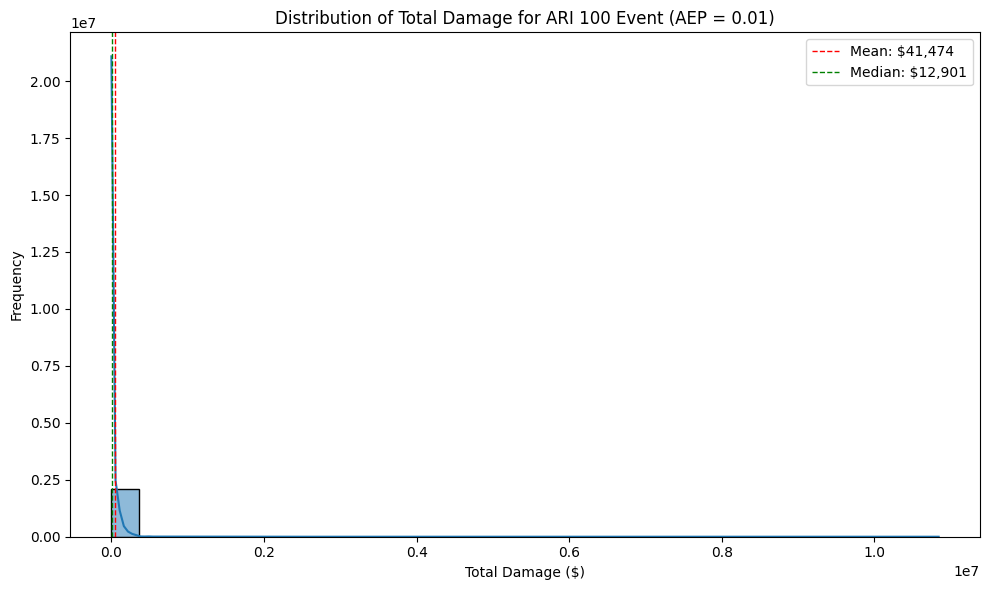

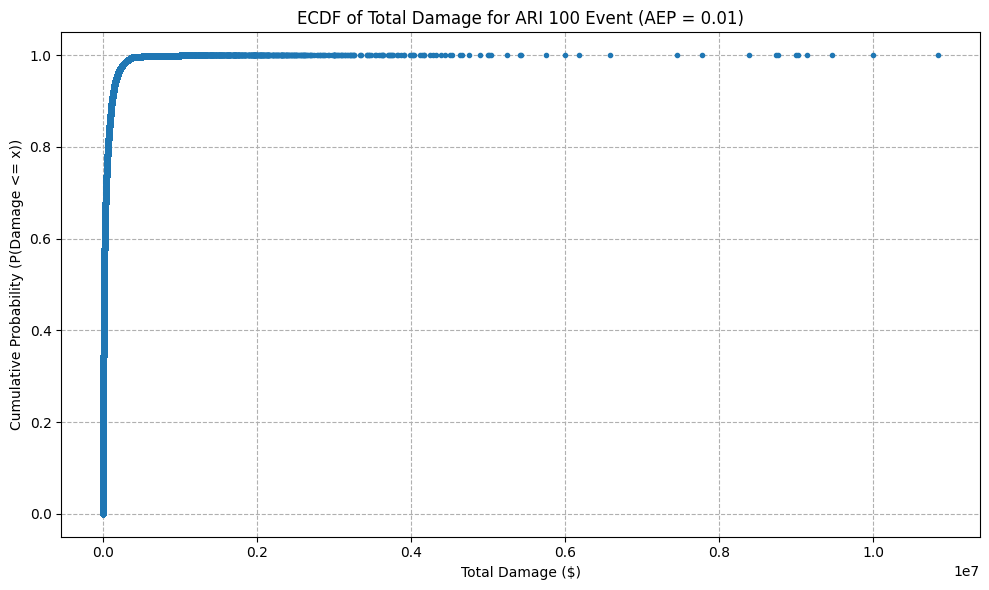

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'df' is your DataFrame.
# If these ARI 100 claims are a subset, filter your DataFrame first.
# For example, if you have a column 'event_ARI' or can identify them otherwise:
# df_ari100 = df[df['event_ARI'] == 100].copy()
# For this example, let's assume 'df_ari100' holds the relevant claims.
# If all claims in your current 'df' are from this event, use df directly.

# Let's simulate df_ari100 for demonstration if you don't have it filtered yet
# Replace this with your actual data loading/filtering
# Ensure 'totalDamage' column exists and is numeric
# Example: df_ari100 = df_cleaned[df_cleaned['some_condition_identifying_ari100_event']]
# For now, I'll assume you have a DataFrame called `claims_for_ari100`

# --- Make sure 'totalDamage' is calculated ---
# This might have been done in previous steps. If not:
# df['buildingDamageAmount'] = pd.to_numeric(df['amountPaidOnBuildingClaim'], errors='coerce')
# df['contentsDamageAmount'] = pd.to_numeric(df['amountPaidOnContentsClaim'], errors='coerce')
# df['totalDamage'] = df['buildingDamageAmount'].fillna(0) + df['contentsDamageAmount'].fillna(0)

# Let's assume you have a DataFrame `claims_for_ari100` that contains
# only the claims known to be from an ARI 100-year event.
# And it has a 'totalDamage' column.
# For demonstration, if your main DataFrame is 'df' and all are from ARI 100:
claims_for_ari100 = df[df['totalDamage'] > 0].copy() # Use a copy with positive damages

if claims_for_ari100.empty:
    print("No claims data available for ARI 100 event analysis.")
else:
    ari_100_aep = 0.01
    print(f"Analyzing damages for events with ARI = 100 years (AEP = {ari_100_aep:.2f})\n")

    # --- Descriptive Statistics for totalDamage ---
    mean_damage = claims_for_ari100['totalDamage'].mean()
    median_damage = claims_for_ari100['totalDamage'].median()
    min_damage = claims_for_ari100['totalDamage'].min()
    max_damage = claims_for_ari100['totalDamage'].max()
    pct_75_damage = claims_for_ari100['totalDamage'].quantile(0.75)
    pct_90_damage = claims_for_ari100['totalDamage'].quantile(0.90)

    print(f"Descriptive Statistics for Total Damage (ARI 100 Event):")
    print(f"  Mean:   ${mean_damage:,.2f}")
    print(f"  Median: ${median_damage:,.2f}")
    print(f"  Min:    ${min_damage:,.2f}")
    print(f"  Max:    ${max_damage:,.2f}")
    print(f"  75th Percentile: ${pct_75_damage:,.2f}")
    print(f"  90th Percentile: ${pct_90_damage:,.2f}")
    print(f"  Number of Claims: {len(claims_for_ari100)}")

    # --- Plot Histogram of Total Damage ---
    plt.figure(figsize=(10, 6))
    sns.histplot(claims_for_ari100['totalDamage'], kde=True, bins=30)
    plt.title(f'Distribution of Total Damage for ARI 100 Event (AEP = {ari_100_aep:.2f})')
    plt.xlabel('Total Damage ($)')
    plt.ylabel('Frequency')
    plt.axvline(mean_damage, color='red', linestyle='dashed', linewidth=1, label=f'Mean: ${mean_damage:,.0f}')
    plt.axvline(median_damage, color='green', linestyle='dashed', linewidth=1, label=f'Median: ${median_damage:,.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Empirical Cumulative Distribution Function (ECDF) of Total Damage ---
    # Sort data for ECDF
    sorted_damage = np.sort(claims_for_ari100['totalDamage'])
    # Calculate ECDF probabilities
    ecdf_probs = np.arange(1, len(sorted_damage) + 1) / len(sorted_damage)

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_damage, ecdf_probs, marker='.', linestyle='none')
    plt.title(f'ECDF of Total Damage for ARI 100 Event (AEP = {ari_100_aep:.2f})')
    plt.xlabel('Total Damage ($)')
    plt.ylabel('Cumulative Probability (P(Damage <= x))')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

In [ ]:
# Assume df_main is your full dataset
# df_ari100 = df_main[df_main['condition_for_ari100_is_true']]
# df_others = df_main[~df_main['condition_for_ari100_is_true']]

# data_points = []

# # Process ARI 100 data
# if not df_ari100.empty:
#     avg_damage_ari100 = df_ari100['totalDamage'].mean()
#     num_claims_ari100 = len(df_ari100)
#     data_points.append({'AEP': 0.01, 'averageTotalDamage': avg_damage_ari100, 'numberOfClaims': num_claims_ari100, 'Source': 'ARI 100 Event'})

# # Process other data using flood zones
# if not df_others.empty:
#     plot_df_others = df_others[['ratedFloodZone', 'totalDamage']].copy()
#     # ... (apply map_flood_zone_to_aep to plot_df_others)
#     # ... (group by AEP and calculate averageTotalDamage and numberOfClaims for plot_df_others)
#     # aep_damage_data_others = ...
#     # for index, row in aep_damage_data_others.iterrows():
#     #     data_points.append({'AEP': row['AEP'], 'averageTotalDamage': row['averageTotalDamage'], 'numberOfClaims': row['numberOfClaims'], 'Source': 'Flood Zone'})

# final_plot_data = pd.DataFrame(data_points)
# final_plot_data = final_plot_data.sort_values('AEP')

# # Then plot final_plot_data using sns.lineplot as before
# # You might want to use different markers or labels based on the 'Source' column